In [1]:
import os
import json
from pycocotools.coco import COCO
import numpy as np 
from matplotlib import pyplot as plt
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as album 
from sklearn.model_selection import train_test_split
from albumentations.pytorch import ToTensorV2
import cv2
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
from datetime import datetime
import time
from sklearn.metrics import jaccard_score

# Data Preprocessing

In [4]:
## Change the local Path here
dt_pth=r'd:\COMP-9517-DeeplabV3+\turtles-data\data'
annotation_file = './turtles-data/data/annotations.json'

In [5]:
with open(os.path.join(dt_pth,"annotations.json"), "r", encoding='utf8') as file:
          dt_dict=json.load(file)

In [6]:
coco = COCO(os.path.join(dt_pth,'annotations.json'))

loading annotations into memory...
Done (t=3.94s)
creating index...
index created!


## Dataset image loading

In [44]:
class SeaTrutleDataset(Dataset):
    def __init__(self, coco, img_ids,
                 augmentation):
        self.coco = coco
        self.img_ids = img_ids
        self.augmentation = augmentation
        self.catIds = coco.getCatIds()

    def __len__(self):
        return len(self.img_ids)
    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_nm = self.coco.loadImgs([img_id])[0]['file_name']
        img = cv2.imread(f"{dt_pth}/{img_nm}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ann_ids = coco.getAnnIds(imgIds=img_id, catIds=self.catIds, iscrowd=None)
        anns = coco.loadAnns(ann_ids)
        mask=np.zeros_like(img[:,:,0])
        for i in range(len(anns)):
            tmp= coco.annToMask(anns[i])
            if anns[i]['category_id']==1:
                mask[(tmp==1) & (mask==0)]=anns[i]['category_id']
            else:
                mask[(tmp==1)]=anns[i]['category_id']
        img = img.astype(np.float32)
        mask = mask.astype(np.float32)
        if self.augmentation:
            transformed = self.augmentation(image=img, mask=mask)
            img = transformed["image"]
            label = transformed["mask"]

        return img, label

In [45]:
def train_augment():
    transform = [
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
        album.RandomRotate90(p=0.5),
        album.Resize(height=256, width=256),
        ToTensorV2()
    ]
    return album.Compose(transform)

def val_augment():
    transform = [
        album.Resize(height=256, width=256),
        ToTensorV2()
    ]
    return album.Compose(transform)

In [46]:
train_ids, test_ids = train_test_split(coco.getImgIds(), test_size=0.2, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.2, random_state=42)
print(len(train_ids), len(val_ids), len(test_ids))

5586 1397 1746


In [47]:
train_dataset = SeaTrutleDataset(coco, train_ids, 
                         augmentation=train_augment()
                         )
val_dataset = SeaTrutleDataset(coco, val_ids,
                            augmentation=val_augment())

test_dataset = SeaTrutleDataset(coco, test_ids,
                            augmentation=val_augment())

# Define Model

In [48]:
class Atrous_Convolution(nn.Module):
    """
    """
    def __init__(
            self, input_channels, kernel_size, pad, dilation_rate,
            output_channels=256):
        super(Atrous_Convolution, self).__init__()

        self.conv = nn.Conv2d(in_channels=input_channels,
                              out_channels=output_channels,
                              kernel_size=kernel_size, padding=pad,
                              dilation=dilation_rate, bias=False)

        self.batchnorm = nn.BatchNorm2d(output_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):

        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

In [49]:
class ASSP(nn.Module):
    """
   Encoder of DeepLabv3+.
    """

    def __init__(self, in_channles, out_channles):
        """Atrous Spatial Pyramid pooling layer
        Args:
            in_channles (int): No of input channel for Atrous_Convolution.
            out_channles (int): No of output channel for Atrous_Convolution.
        """
        super(ASSP, self).__init__()
        self.conv_1x1 = Atrous_Convolution(
            input_channels=in_channles, output_channels=out_channles,
            kernel_size=1, pad=0, dilation_rate=1)

        self.conv_6x6 = Atrous_Convolution(
            input_channels=in_channles, output_channels=out_channles,
            kernel_size=3, pad=6, dilation_rate=6)

        self.conv_12x12 = Atrous_Convolution(
            input_channels=in_channles, output_channels=out_channles,
            kernel_size=3, pad=12, dilation_rate=12)

        self.conv_18x18 = Atrous_Convolution(
            input_channels=in_channles, output_channels=out_channles,
            kernel_size=3, pad=18, dilation_rate=18)

        self.image_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(
                in_channels=in_channles, out_channels=out_channles,
                kernel_size=1, stride=1, padding=0, dilation=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True))

        self.final_conv = Atrous_Convolution(
            input_channels=out_channles * 5, output_channels=out_channles,
            kernel_size=1, pad=0, dilation_rate=1)

    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_6x6 = self.conv_6x6(x)
        x_12x12 = self.conv_12x12(x)
        x_18x18 = self.conv_18x18(x)
        img_pool_opt = self.image_pool(x)
        img_pool_opt = F.interpolate(
            img_pool_opt, size=x_18x18.size()[2:],
            mode='bilinear', align_corners=True)
    # concatination of all features
        concat = torch.cat(
            (x_1x1, x_6x6, x_12x12, x_18x18, img_pool_opt),
            dim=1)
        x_final_conv = self.final_conv(concat)
        return x_final_conv

In [50]:
class ResNet_50(nn.Module):
    def __init__(self, output_layer=None):
        super(ResNet_50, self).__init__()
        self.pretrained = models.resnet50(pretrained=True)
        self.output_layer = output_layer
        self.layers = list(self.pretrained._modules.keys())
        self.layer_count = 0
        for l in self.layers:
            if l != self.output_layer:
                self.layer_count += 1
            else:
                break
        for i in range(1, len(self.layers)-self.layer_count):
            self.dummy_var = self.pretrained._modules.pop(self.layers[-i])
        self.net = nn.Sequential(self.pretrained._modules)
        self.pretrained = None

    def forward(self, x):
        x = self.net(x)
        return x 

In [51]:
class Deeplabv3Plus(nn.Module):
    def __init__(self, num_classes):

        super(Deeplabv3Plus, self).__init__()

        self.backbone = ResNet_50(output_layer='layer3') # b*1024*32*32

        self.low_level_features = ResNet_50(output_layer='layer1') # b*256*128*128

        self.assp = ASSP(in_channles=1024, out_channles=256)

        self.conv1x1 = Atrous_Convolution(
            input_channels=256, output_channels=48, kernel_size=1,
            dilation_rate=1, pad=0)

        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(304, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.classifer = nn.Conv2d(256, num_classes, 1)

    def forward(self, x):

        x_backbone = self.backbone(x) #b*1024*32*32
        x_low_level = self.low_level_features(x) # b*256*128*128
        x_assp = self.assp(x_backbone) # b*256*32*32
        x_assp_upsampled = F.interpolate(
            x_assp, scale_factor=(4, 4),
            mode='bilinear', align_corners=True) # b*256*128*128
        x_conv1x1 = self.conv1x1(x_low_level) # b*48*128*128
        x_cat = torch.cat([x_conv1x1, x_assp_upsampled], dim=1) # b* 304*128*128
        x_3x3 = self.conv_3x3(x_cat) # b*256 *128*128
        x_3x3_upscaled = F.interpolate(
            x_3x3, scale_factor=(4, 4),
            mode='bilinear', align_corners=True)# b*256 *512*512
        x_out = self.classifer(x_3x3_upscaled)
        return x_out

# Generate Dataloaer

In [52]:
batch_size=8
num_workers=0
train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )
val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )
test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )

# Hyperparameter determination

In [53]:
LEARNING_RATE = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
NUM_EPOCHS = 50
PIN_MEMORY = True
LOAD_MODEL = False

# Define loss and optimizer

In [21]:
model=Deeplabv3Plus(4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 

d:\python3.11\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\python3.11\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
# Training loop
loss_history = []
total_batches = len(train_loader)

model.to(DEVICE)

for epoch in range(NUM_EPOCHS):
    model.train()  # Set model to training mode
    running_loss = 0.0
    print(f'Starting epoch {epoch + 1} / {NUM_EPOCHS}')
    # Training phase；
    # Adjust the loss function


    for batch_idx, (images, masks) in enumerate(train_loader):
        start_time = time.time()
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        optimizer.zero_grad()
        # print(f'start time: {start_time}')
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks.long())  # CrossEntropyLoss expects integer labels
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        running_loss += loss.item() * images.size(0)

        # Print progress every 10 batches
        if (batch_idx+1) % 10 == 0:
            print(f"Batch {batch_idx}/{total_batches} - Loss: {loss.item():.4f} - Time: {time.time() - start_time:.2f}s")

    # Average loss over training data
    avg_training_loss = running_loss / len(train_loader.dataset)
    loss_history.append(avg_training_loss)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Average Training Loss: {avg_training_loss:.4f}")

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # No need to track gradients during validation
        for images, masks in val_loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks.long())

            val_loss += loss.item() * images.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Validation Loss: {avg_val_loss:.4f}")

Starting epoch 1 / 50
Batch 9/699 - Loss: 0.3950 - Time: 0.12s
Batch 19/699 - Loss: 0.2204 - Time: 0.15s
Batch 29/699 - Loss: 0.2547 - Time: 0.12s
Batch 39/699 - Loss: 0.2231 - Time: 0.12s
Batch 49/699 - Loss: 0.1223 - Time: 0.12s
Batch 59/699 - Loss: 0.1129 - Time: 0.12s
Batch 69/699 - Loss: 0.2905 - Time: 0.12s
Batch 79/699 - Loss: 0.1768 - Time: 0.12s
Batch 89/699 - Loss: 0.2018 - Time: 0.12s
Batch 99/699 - Loss: 0.1342 - Time: 0.12s
Batch 109/699 - Loss: 0.0651 - Time: 0.12s
Batch 119/699 - Loss: 0.1966 - Time: 0.12s
Batch 129/699 - Loss: 0.0879 - Time: 0.12s
Batch 139/699 - Loss: 0.1645 - Time: 0.12s
Batch 149/699 - Loss: 0.1882 - Time: 0.12s
Batch 159/699 - Loss: 0.1480 - Time: 0.12s
Batch 169/699 - Loss: 0.1214 - Time: 0.12s
Batch 179/699 - Loss: 0.1033 - Time: 0.12s
Batch 189/699 - Loss: 0.1339 - Time: 0.12s
Batch 199/699 - Loss: 0.0590 - Time: 0.12s
Batch 209/699 - Loss: 0.0829 - Time: 0.12s
Batch 219/699 - Loss: 0.1054 - Time: 0.12s
Batch 229/699 - Loss: 0.0758 - Time: 0.12s


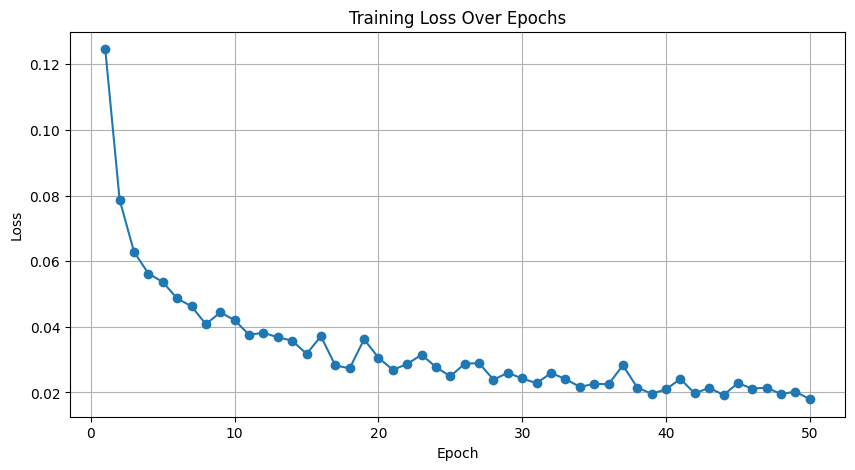

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), loss_history, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

In [ ]:
## save the result of model
current_time = datetime.now().strftime("%Y%m%d_%H%M")
model_filenm=f"deeplabv3_{current_time}.pth"
torch.save(model,model_filenm)
print(f"Save entire model to {model_filenm}")

Save entire model to deeplabv3_20241105_0137.pth


In [ ]:
## Load saved path
## Please see the Readme and downLoad the model training data
checkpoint_path = 'deeplabv3_20241105_0137.pth'
model = torch.load(checkpoint_path)

C:\Users\Jaclson\AppData\Local\Temp\ipykernel_29900\832972531.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(checkpoint_path)


In [59]:
def cal_iou(y_pred, y_true):
    y_true=y_true.flatten().astype(int)
    y_pred=y_pred.flatten().astype(int)
    IoUs = jaccard_score(y_true,y_pred, average=None)
    mIoU = jaccard_score(y_true,y_pred,  average='macro')
    return mIoU,IoUs

# Test Performance

In [60]:
def test_model(model,test_loader):
    model.eval()
    pred_lst=[]
    target_lst=[]
    with torch.no_grad():
        for images, masks in test_loader:
            images=images.to(DEVICE)
            outputs=model(images)
            pred_mask=torch.argmax(outputs,dim=1)
            target_lst.append(masks)
            pred_lst.append(pred_mask)
    target=torch.cat(target_lst,dim=0).cpu().numpy()
    pred=torch.cat(pred_lst,dim=0).cpu().numpy()
    mIoU,IoUs=cal_iou(pred,target)
    return mIoU,IoUs

In [57]:
mIoU,IoUs=test_model(model,test_loader)
print(f"The total Mean IoU of turtles is :{mIoU:.2%}")
print(f"The Mean IoU of Head:{IoUs[2]:.2%}")
print(f"The Mean IoU of Carapace:{IoUs[1]:.2%}")
print(f"The Mean IoU of Flippers:{IoUs[3]:.2%}")

The total Mean IoU of turtles is :92.04%
The Mean IoU of Head:85.74%
The Mean IoU of Carapace:93.33%
The Mean IoU of Flippers:89.67%


In [61]:
def show_predict(model,dataset,index,device):
    model.eval()
    image,mask=dataset[index]
    image=image.to(device).unsqueeze(0)

    with torch.no_grad():
        pred=model(image)
        pred_mask=torch.argmax(pred,dim=1).squeeze().cpu().int().numpy()
    mask=mask.cpu().squeeze().int().numpy()
    mIoU,IoUs=cal_iou(pred_mask, mask)
    
    _, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image.int().squeeze().permute(1, 2, 0).cpu())  # Display the image
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(mask, cmap="viridis", interpolation="nearest")
    axs[1].set_title("Truth Mask")
    axs[1].axis("off")

    axs[2].imshow(pred_mask, cmap="viridis", interpolation="nearest")
    axs[2].set_title(f"Predicted Mask, mIoU: {mIoU:.2%}")
    axs[2].axis("off")
    
    print(f"The Mean IoU of this picture is :{mIoU:.2%}")
    print(f"The IoU of Head:{IoUs[2]:.2%}")
    print(f"The IoU of Carapace:{IoUs[1]:.2%}")
    print(f"The IoU of Flippers:{IoUs[3]:.2%}")
    plt.show()

The Mean IoU of this picture is :95.60%
The IoU of Head:93.52%
The IoU of Carapace:98.54%
The IoU of Flippers:90.61%


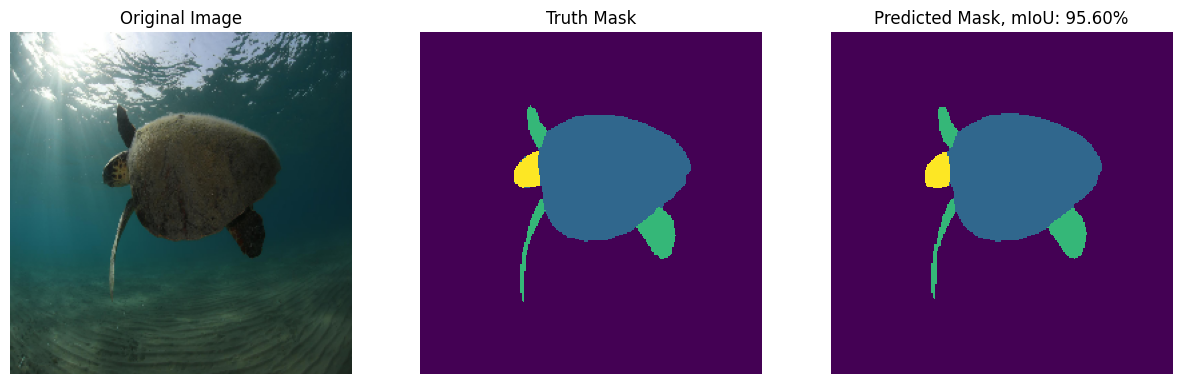

In [62]:
## The performance on other images can be checked in the test_dataset by changing the index value.
show_predict(model,test_dataset,10,DEVICE)